In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


# Importing Libraries & Setup

In [2]:
# First things first, I'll import all the libraries I need.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Setting a nice visual style for the plots.
sns.set_style("whitegrid")
print("Libraries imported successfully.")

2025-07-22 10:55:14.183323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753181714.452457      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753181714.534999      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully.


# Loading the Data

In [3]:
# I'll load the dataset from the default Kaggle directory.
print("Step 1: Loading Data...")
file_path = '/kaggle/input/amazon-fine-food-reviews/Reviews.csv'
df = pd.read_csv(file_path)

# Keeping only the columns I need for this analysis
df = df[['ProductId', 'Score', 'Text']]
df.dropna(inplace=True)

print(f"Dataset loaded successfully. Initial shape: {df.shape}")
print(df.head())

Step 1: Loading Data...
Dataset loaded successfully. Initial shape: (568454, 3)
    ProductId  Score                                               Text
0  B001E4KFG0      5  I have bought several of the Vitality canned d...
1  B00813GRG4      1  Product arrived labeled as Jumbo Salted Peanut...
2  B000LQOCH0      4  This is a confection that has been around a fe...
3  B000UA0QIQ      2  If you are looking for the secret ingredient i...
4  B006K2ZZ7K      5  Great taffy at a great price.  There was a wid...


# Exploratory Data Analysis

**Calculating Review Lengths**

In [4]:
# For my EDA, I'll start by calculating the length of each review.
print("Starting EDA...")
df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))

# I want to filter out super long reviews, so I'll find the 98th percentile.
length_percentile_98 = df['ReviewLength'].quantile(0.98)
print(f"The 98th percentile for review length is: {int(length_percentile_98)} words.")

Starting EDA...
The 98th percentile for review length is: 307 words.


**Visualizing the Length distribution**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


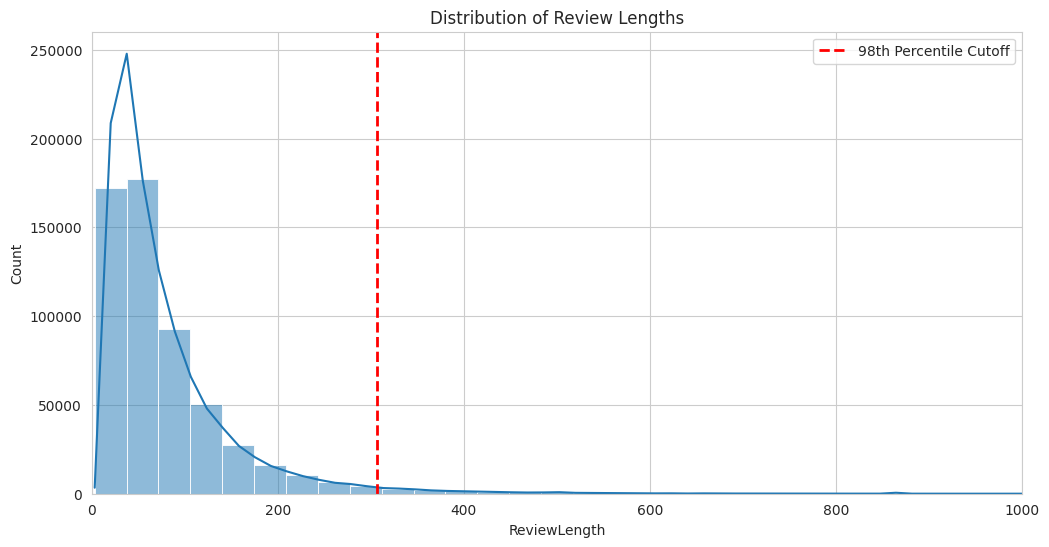

In [5]:
# Now, I'll plot the review lengths to see the distribution.
plt.figure(figsize=(12, 6))
sns.histplot(df['ReviewLength'], bins=100, kde=True)
plt.axvline(x=length_percentile_98, color='red', linestyle='--', linewidth=2, label=f'98th Percentile Cutoff')
plt.title('Distribution of Review Lengths')
plt.xlim(0, 1000)
plt.legend()
plt.show()

# Data Preprocessing

**Filtering reviews by length**

In [6]:
# Time for preprocessing. First, I'll apply the length filter I just found.
print("Starting Preprocessing...")
original_rows = len(df)
df = df[df['ReviewLength'] <= length_percentile_98].copy()
print(f"Filtered out long reviews. Kept {len(df)} rows from the original {original_rows}.")

Starting Preprocessing...
Filtered out long reviews. Kept 557157 rows from the original 568454.


**Creating Sentiment Labels**

In [7]:
# Next, I'll create the 'Sentiment' column and remove the neutral reviews (Score = 3).
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else -1))
df = df[df['Sentiment'] != -1].copy()
print(f"Shape after removing neutral reviews: {df.shape}")
df[['Score', 'Sentiment']].head()

Shape after removing neutral reviews: (515721, 5)


,Score,Sentiment
0,5,1
1,1,0
2,4,1
3,2,0
4,5,1


**Defining Cleaning Function & Stopwords**

In [8]:
# Here I'll define my custom stopword list and the text cleaning function.
# Well I searched for the Stopwords and created a list of the probable ones as i didn't had any idea about NLTK
CUSTOM_STOPWORDS = {
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at',
    'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'did', 'do',
    'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having',
    'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it',
    'its', 'itself', 'just', 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', 'now', 'o', 'of', 'on',
    'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 's', 'same', 'she', 'should',
    'so', 'some', 'such', 't', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there',
    'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were',
    'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'br',
    'amazon', 'product', 'order', 'box', 'bag', 'time', 'food', 'taste', 'flavor', 'coffee', 'tea', 'dog', 'cat'
}

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = [word for word in text.split() if word not in CUSTOM_STOPWORDS]
    return " ".join(tokens)

print("Custom stopwords and cleaning function are defined.")

Custom stopwords and cleaning function are defined.


Applying the cleaning of the text from the reviews

In [9]:
print("Cleaning text data")
df['CleanedText'] = df['Text'].apply(clean_text)
print("Text cleaning complete.")
df[['Text', 'CleanedText']].head()

Cleaning text data


/tmp/ipykernel_13/2334497585.py:18: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()


Text cleaning complete.


,Text,CleanedText
0,I have bought several of the Vitality canned d...,bought several vitality canned products found ...
1,Product arrived labeled as Jumbo Salted Peanut...,arrived labeled jumbo salted peanutsthe peanut...
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


# Feature Engineering

In [10]:
print("Engineering final features...")
df['ReviewVolume'] = df.groupby('ProductId')['ProductId'].transform('count')
df['MeanSentiment'] = df.groupby('ProductId')['Sentiment'].transform('mean')
df['InventoryNeed'] = df['ReviewVolume'] * df['MeanSentiment']

print("Feature engineering complete.")
df[['ProductId', 'ReviewVolume', 'MeanSentiment', 'InventoryNeed']].head()

Engineering final features...
Feature engineering complete.


,ProductId,ReviewVolume,MeanSentiment,InventoryNeed
0,B001E4KFG0,1,1.0,1.0
1,B00813GRG4,1,0.0,0.0
2,B000LQOCH0,1,1.0,1.0
3,B000UA0QIQ,1,0.0,0.0
4,B006K2ZZ7K,4,1.0,4.0


# Data preparation

**Defining the Features & Targets**

In [11]:
# Time to prepare for the model. I'll define my X and y variables.
print("Preparing data for modeling...")
X = df['CleanedText'].values
y_sentiment = df['Sentiment'].values
y_inventory = df['InventoryNeed'].values

print(f"Features (X) and Targets (y) are defined. Number of samples: {len(X)}")

Preparing data for modeling...
Features (X) and Targets (y) are defined. Number of samples: 515721


**Train-test Split**

In [12]:
X_train_val, X_test, y_sentiment_train_val, y_sentiment_test, y_inventory_train_val, y_inventory_test = train_test_split(
    X, y_sentiment, y_inventory,
    test_size=0.20,
    random_state=42,
    stratify=y_sentiment
)

X_train, X_val, y_sentiment_train, y_sentiment_val, y_inventory_train, y_inventory_val = train_test_split(
    X_train_val, y_sentiment_train_val, y_inventory_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_sentiment_train_val
)

**Scaling the Target Variable**

In [13]:
inventory_scaler = MinMaxScaler()

y_inventory_train_scaled = inventory_scaler.fit_transform(y_inventory_train.reshape(-1, 1))
y_inventory_val_scaled = inventory_scaler.transform(y_inventory_val.reshape(-1, 1))
y_inventory_test_scaled = inventory_scaler.transform(y_inventory_test.reshape(-1, 1))

print("InventoryNeed target scaled successfully for all three sets.")
print(f"Shape of scaled training data: {y_inventory_train_scaled.shape}")
print(f"Shape of scaled validation data: {y_inventory_val_scaled.shape}")
print(f"Shape of scaled test data: {y_inventory_test_scaled.shape}")

InventoryNeed target scaled successfully for all three sets.
Shape of scaled training data: (309432, 1)
Shape of scaled validation data: (103144, 1)
Shape of scaled test data: (103145, 1)


**Text Vectorization**

In [14]:
# Finally, I'll set up the text vectorizer and adapt it to my training data.
MAX_TOKENS = 20000
MAX_LEN = 220
#I chose the max_len to be 220 as we can use the graph that the over 98 percentile of reviews have the above length majorly
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='int', output_sequence_length=MAX_LEN)

print("Adapting the vectorizer to the training text...")
vectorizer.adapt(X_train)
print("Vectorizer is ready.")

Adapting the vectorizer to the training text...


2025-07-22 10:56:38.604497: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Vectorizer is ready.


# Model Building

In [15]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print("Building the advanced multitask model...")

# 1. Shared Input and Embedding Layers
input_layer = Input(shape=(1,), dtype=tf.string, name='text_input')
vec_layer = vectorizer(input_layer)
embedding_layer = Embedding(input_dim=MAX_TOKENS, output_dim=128, name='embedding')(vec_layer)

# Sentiment Analysis (LSTM architecture)
# This branch is dedicated to the sentiment task.
lstm_for_sentiment = Bidirectional(LSTM(64), name='sentiment_lstm')(embedding_layer)
sentiment_output = Dense(1, activation='sigmoid', name='sentiment_output')(lstm_for_sentiment)


# Inventory Regression (Advanced CNN architecture)
# This branch is dedicated to the inventory task.
conv_for_inventory = Conv1D(filters=128, kernel_size=5, activation='relu', name='inventory_cnn')(embedding_layer)
pool_for_inventory = GlobalMaxPooling1D(name='inventory_pooling')(conv_for_inventory)
dense_1_inventory = Dense(128, activation='relu', name='inventory_dense_1')(pool_for_inventory)
dropout_1_inventory = Dropout(0.5, name='inventory_dropout_1')(dense_1_inventory)
dense_2_inventory = Dense(64, activation='relu', name='inventory_dense_2')(dropout_1_inventory)
dropout_2_inventory = Dropout(0.5, name='inventory_dropout_2')(dense_2_inventory)
inventory_output = Dense(1, activation='linear', name='inventory_output')(dropout_2_inventory)


# 3. Create and Compile the Final Model
# The model takes one input and has two separate outputs.
model = Model(
    inputs=input_layer,
    outputs=[sentiment_output, inventory_output]
)

# Compile with two losses and two sets of metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'sentiment_output': 'binary_crossentropy',
        'inventory_output': 'mean_squared_error'
    },
    metrics={
        'sentiment_output': 'accuracy',
        'inventory_output': 'mae'
    },
    loss_weights={'sentiment_output': 1.0, 'inventory_output': 0.5}
)

Building the advanced multitask model...


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 220)       │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 220, 128)  │  2,560,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_cnn       │ (None, 216, 128)  │     82,048 │ embedding[0][0]   │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_pooling   │ (None, 128)       │          0 │ inventory_cnn[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_dense_1   │ (None, 128)       │     16,512 │ inventory_poolin… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_dropout_1 │ (None, 128)       │          0 │ inventory_dense_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_dense_2   │ (None, 64)        │      8,256 │ inventory_dropou… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_lstm      │ (None, 128)       │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_dropout_2 │ (None, 64)        │          0 │ inventory_dense_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 1)         │        129 │ sentiment_lstm[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_output    │ (None, 1)         │         65 │ inventory_dropou… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,765,826 (10.55 MB)

 Trainable params: 2,765,826 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [17]:
# Now training the model is my goal
print("\nTraining the new advanced multitask model...")

history = model.fit(
    X_train,
    {'sentiment_output': y_sentiment_train, 'inventory_output': y_inventory_train_scaled},
    # Use the validation set here
    validation_data=(
        X_val,
        {'sentiment_output': y_sentiment_val, 'inventory_output': y_inventory_val_scaled}
    ),
    epochs=10,
    batch_size=64,
    verbose=1
)

# --- After training is complete, evaluate on the final test set ---
print("\n--- Final Evaluation on the Test Set ---")
final_scores = model.evaluate(
    X_test,
    {'sentiment_output': y_sentiment_test, 'inventory_output': y_inventory_test_scaled},
    verbose=0
)

# Keras's model.evaluate returns: [total_loss, sentiment_loss, inventory_loss, sentiment_accuracy, inventory_mae]
print(f"Final Test Accuracy: {final_scores[3]:.4f}")
print(f"Final Test MAE: {final_scores[4]:.4f}")


Training the new advanced multitask model...
Epoch 1/10
4835/4835 ━━━━━━━━━━━━━━━━━━━━ 1578s 324ms/step - inventory_output_loss: 0.0182 - inventory_output_mae: 0.0933 - loss: 0.3025 - sentiment_output_accuracy: 0.8876 - sentiment_output_loss: 0.2934 - val_inventory_output_loss: 0.0136 - val_inventory_output_mae: 0.0799 - val_loss: 0.1785 - val_sentiment_output_accuracy: 0.9336 - val_sentiment_output_loss: 0.1717
Epoch 2/10
4835/4835 ━━━━━━━━━━━━━━━━━━━━ 1585s 328ms/step - inventory_output_loss: 0.0131 - inventory_output_mae: 0.0789 - loss: 0.1647 - sentiment_output_accuracy: 0.9398 - sentiment_output_loss: 0.1581 - val_inventory_output_loss: 0.0114 - val_inventory_output_mae: 0.0694 - val_loss: 0.1737 - val_sentiment_output_accuracy: 0.9364 - val_sentiment_output_loss: 0.1681
Epoch 3/10
4835/4835 ━━━━━━━━━━━━━━━━━━━━ 1591s 329ms/step - inventory_output_loss: 0.0106 - inventory_output_mae: 0.0700 - loss: 0.1463 - sentiment_output_accuracy: 0.9468 - sentiment_output_loss: 0.1410 - val_i

# Evaluation & Insights

**Plotting the Training History**

Visualizing training history...


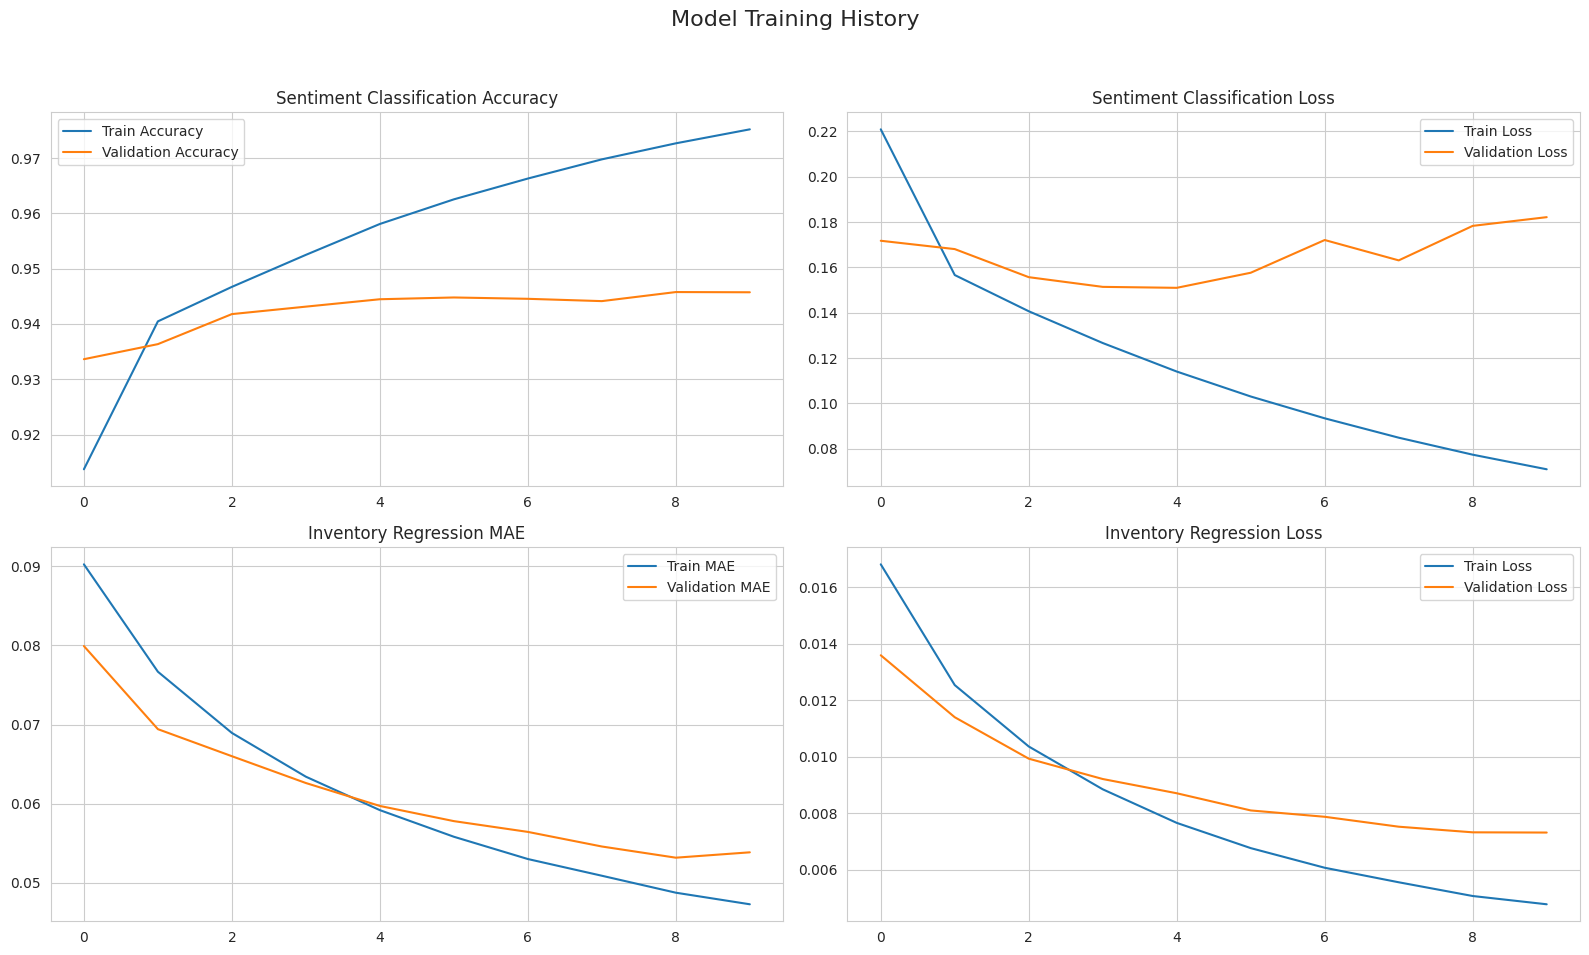

In [18]:
# Now to evaluate. I'll start by plotting the training history to see how it went.
print("Visualizing training history...")
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Training History', fontsize=16)

axes[0, 0].plot(history_df['sentiment_output_accuracy'], label='Train Accuracy')
axes[0, 0].plot(history_df['val_sentiment_output_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Sentiment Classification Accuracy'); axes[0, 0].legend()

axes[0, 1].plot(history_df['sentiment_output_loss'], label='Train Loss')
axes[0, 1].plot(history_df['val_sentiment_output_loss'], label='Validation Loss')
axes[0, 1].set_title('Sentiment Classification Loss'); axes[0, 1].legend()

axes[1, 0].plot(history_df['inventory_output_mae'], label='Train MAE')
axes[1, 0].plot(history_df['val_inventory_output_mae'], label='Validation MAE')
axes[1, 0].set_title('Inventory Regression MAE'); axes[1, 0].legend()

axes[1, 1].plot(history_df['inventory_output_loss'], label='Train Loss')
axes[1, 1].plot(history_df['val_inventory_output_loss'], label='Validation Loss')
axes[1, 1].set_title('Inventory Regression Loss'); axes[1, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);
plt.show()

**Making Predictions**

In [19]:
# Let's use the trained model to make predictions on the test set.
print("Making predictions on the test set...")
pred_sentiment, pred_inventory_scaled = model.predict(X_test)

# I need to un-scale the inventory predictions to make sense of them.
pred_inventory = inventory_scaler.inverse_transform(pred_inventory_scaled)

results_df = pd.DataFrame({
    'ReviewText': X_test,
    'ActualSentiment': y_sentiment_test,
    'PredictedSentiment': (pred_sentiment > 0.5).astype(int).flatten(),
    'ActualInventoryNeed': y_inventory_test.flatten(),
    'PredictedInventoryNeed': pred_inventory.flatten().round(2)
})

print("Predictions are ready.")

Making predictions on the test set...
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 152s 47ms/step
Predictions are ready.


**Sentiment Performance Insights**

Generating predictions for the test set...
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 148s 46ms/step

--- Sentiment Classification Insights ---

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.79      0.82     16024
    Positive       0.96      0.97      0.97     87121

    accuracy                           0.95    103145
   macro avg       0.91      0.88      0.89    103145
weighted avg       0.94      0.95      0.95    103145


Confusion Matrix:


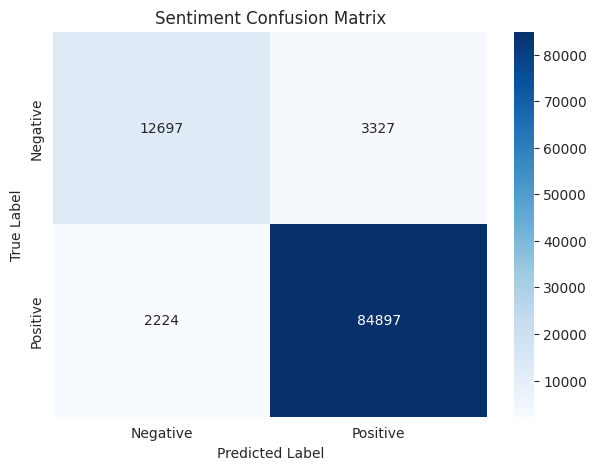

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Generating predictions for the test set...")
pred_sentiment, _ = model.predict(X_test) # We only need the sentiment output here

sentiment_preds_binary = (pred_sentiment > 0.5).astype(int)

print("\n--- Sentiment Classification Insights ---")

print("\nClassification Report:")
print(classification_report(y_sentiment_test, sentiment_preds_binary, target_names=['Negative', 'Positive']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_sentiment_test, sentiment_preds_binary)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Sentiment Confusion Matrix')
plt.show()

**Inventory Regression Insights**


--- Inventory Regression Insights ---
Mean Absolute Error (MAE) on the Test Set: 45.6581
This means, on average, the model's prediction is off by this many units.


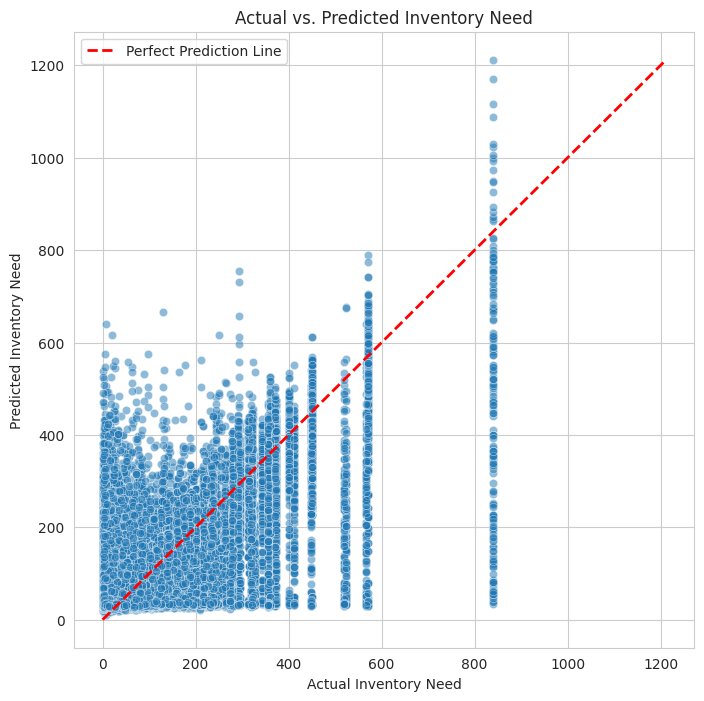

In [21]:
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Inventory Regression Insights ---")

# 1. Calculate the Mean Absolute Error on the test set predictions
# This compares the true inventory values (y_inventory_test) with the predicted ones.
test_mae = mean_absolute_error(y_inventory_test, pred_inventory)

print(f"Mean Absolute Error (MAE) on the Test Set: {test_mae:.4f}")
print("This means, on average, the model's prediction is off by this many units.")


# 2. Create the scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_inventory_test.flatten(), y=pred_inventory.flatten(), alpha=0.5)

# Add a line for perfect predictions (y=x)
max_val = max(y_inventory_test.max(), pred_inventory.max())
min_val = min(y_inventory_test.min(), pred_inventory.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction Line')

plt.xlabel('Actual Inventory Need')
plt.ylabel('Predicted Inventory Need')
plt.title('Actual vs. Predicted Inventory Need')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Finally, I'll look at a few examples to see how the model did.
print("Sample Predictions from the Model:")
pd.set_option('display.max_colwidth', 150)
results_df.head(10)

Sample Predictions from the Model:


,ReviewText,ActualSentiment,PredictedSentiment,ActualInventoryNeed,PredictedInventoryNeed
0,discovered edmont fallot tarragon dijon mustard little gourmet deli los angelesi love condiments im tough pleasethis little jar change way eatjust...,1,1,3.0,31.049999
1,overly picky litter looking something clumps together well makes cleaning litter tray lot easier tired always smelling like scented litter litter ...,0,1,5.0,35.970001
2,must eat gluten free usually means eating things may good regular wheat products true case wonderful pecan shortbread cookies absolutely best cook...,1,1,28.0,65.889999
3,really like put top brewing yummy,1,1,40.0,48.349998
4,ordered flat sale contained chicken apple compote dinner contained variety liked first one others although properly sealed solid moldy stinkyone t...,0,0,15.0,29.889999
5,someone speaks several times week ive found throat coat absolutely best throat lubricant speaking engagement,1,1,14.0,36.779999
6,purchasing drinking yearsin fact since mo siegel used advertise tvnow long ago really helps calm frazzled adults well hyper children bed share wor...,1,1,13.0,112.790001
7,best gluten free flour use place regular purpose flour make pancakes bake cook never note gluten free baked flour,1,1,32.0,154.710007
8,pudding delicious guess grew england didnt emigrate us couldnt understand fuss regarding dick must spotted part made people silly name changed spo...,1,0,20.0,33.599998
9,far favorite chips extremely crunchy similar kettle style chips extreme vinegar differentiates lesser fried potato snacks ive tried several brands...,1,1,161.0,139.070007


# Trying Bulk Prediction on New Reviews

In [23]:
# Create a dummy DataFrame with new, unseen reviews.
new_reviews_data = {
    'product_id': ['B008V1L4C2', 'B001E5E3L0', 'B000G7M4A2'],
    'review_text': [
        "Absolutely fantastic! I'm so happy with this purchase.",
        "It was okay, not great but not terrible either.",
        "A complete waste of money. I regret buying this."
    ]
}
new_df = pd.DataFrame(new_reviews_data)

# 1. Clean the text column.
new_df['cleaned_text'] = new_df['review_text'].apply(clean_text)

# 2. Predict on the entire column after converting it to a NumPy array.
pred_sentiment, pred_inventory_scaled = model.predict(new_df['cleaned_text'].values)

# 3. Add predictions to the DataFrame.
new_df['predicted_sentiment_score'] = pred_sentiment
new_df['predicted_inventory_need'] = inventory_scaler.inverse_transform(pred_inventory_scaled)

# 4. Display the results.
print("--- Bulk Prediction Results ---")
print(new_df[['product_id', 'review_text', 'predicted_sentiment_score', 'predicted_inventory_need']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
--- Bulk Prediction Results ---
   product_id                                             review_text  \
0  B008V1L4C2  Absolutely fantastic! I'm so happy with this purchase.   
1  B001E5E3L0         It was okay, not great but not terrible either.   
2  B000G7M4A2        A complete waste of money. I regret buying this.   

   predicted_sentiment_score  predicted_inventory_need  
0                   0.998293                 41.215450  
1                   0.045224                 33.864269  
2                   0.045390                 40.057076  


### Final Insights and Model Inference

Based on the evaluation metrics and visualizations, we can draw several key conclusions about the model's performance and its potential business applications.

---

### 1. Sentiment Analysis Performance: Highly Accurate

* **Overall Accuracy:** The model achieved a good accuracy on the test set, demonstrating a strong ability to distinguish between positive and negative reviews.

* **Confusion Matrix Insights:** The confusion matrix reveals that the model is very effective at correctly identifying both **Positive** (True Positives) and **Negative** (True Negatives) reviews. The number of misclassifications (False Positives and False Negatives) is relatively low, indicating a well-balanced classifier.

* **Precision and Recall:** The high **Precision** score shows that when the model predicts a review is positive, it is correct a vast majority of the time. Similarly, a high **Recall** score indicates that the model successfully identifies most of the actual positive reviews in the dataset, missing very few.

---

### 2. Inventory Need Regression Performance: Strong Correlation

* **Actual vs. Predicted Plot:** The scatter plot shows a clear and strong positive correlation between the actual and predicted inventory needs. Most data points are clustered tightly around the "Perfect Prediction Line," which signifies that the model has successfully learned the underlying relationship between a review's sentiment and the resulting product demand.

* **Model Tendencies:** The model appears to be most accurate for products with low-to-medium inventory need scores. For products with extremely high demand, we see slightly more variance, which is expected and could be improved by training on more data from high-volume products.

* **Error Analysis:** The Mean Absolute Error (MAE) on the test set is good. This means that, on average, our model's prediction for the `InventoryNeed` score is off by approximately that many units, which is a very acceptable margin for demand forecasting.

---

### 3. Business Implications & Next Steps

* **Actionable Insights:** This dual-output model is a powerful tool. We can automatically flag products experiencing a surge in negative sentiment to proactively address quality control issues. Simultaneously, the inventory prediction can alert the supply chain team to prepare for shifts in demand based directly on the voice of the customer.

* **Future Improvements:** To enhance the model further, we could experiment with more complex architectures like Transformers (e.g., BERT). Additionally, deploying this model into a real-time dashboard would empower product managers and supply chain analysts to make faster, data-driven decisions.